<a href="https://colab.research.google.com/github/jiinpark21/ESAA_24-2/blob/main/1%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C_0906_%EB%AA%A8%EB%8D%B8%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

과제 : 핸즈온 4장 모델 훈련

p.157-203

# [Chapter 4] 모델 훈련

－ 선형 회귀
  
    － 공식을 사용하여 훈련 세트에 가장 잘 맞는 모델 파라미터 구하기
    － 경사 하강법 ： 모델 파라미터를 조금씩 바꾸면서 비용 함수를 훈련 세트에 대해 최소화

－ 다항 회귀 ： 비선형 데이터셋 훈련에 사용

－ 학습 곡선 ： 모델 과대적합 감지

－ 규제 기법

－ 분류 ： 로지스틱， 소프트맥스 회귀

## 4.1 선형회귀

- 입력 특성의 가중치 합과 편향(절편)이라는 상수를 더해 예측 생성



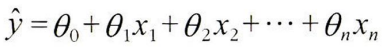
  - ŷ : 예측값
  - n : 특성의 수
  - $x_{i}$ : i번째 특성값
  - $θ_{j}$ : j번째 모델 파라미터



- 모델 훈련 : 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정하는 것
  - 선형 회귀 모델 훈련 : RMSE를 최소화하는 $θ$를 찾아야 함
  - 실제로 RMSE보다 MSE(평균 제곱 오차)를 최소화하는 것이 같은 결과를 내면서 더 간단함

### 4.1.1 정규방정식
- 정규 방정식 : 비용 함수를 최소화하는 $θ$값을 찾기 위한 방정식

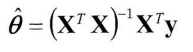

In [ ]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)


In [ ]:
X_b = np.c_[np.ones((100,1)), X] # 모든 샘플에 x0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [ ]:
theta_best

array([[4.56686608],
       [2.66713456]])

- $θ_{0} = 4.57$, $θ_{1} = 2.67$로 매우 비슷하지만 잡음 때문에 원래 함수의 파라미터를 정확히 재현하지 못함

In [ ]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.56686608],
       [9.90113519]])

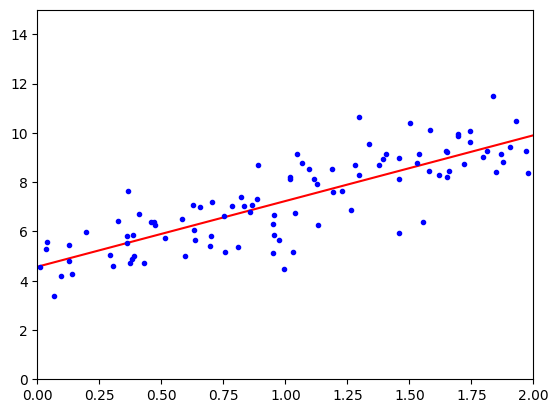

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.56686608]), array([[2.66713456]]))

In [ ]:
lin_reg.predict(X_new)

array([[4.56686608],
       [9.90113519]])

- scipy.linalg.lstsq() : $ \hat{θ}= X^{+}y$ 계산하는 함수
  - $X^{+}$ : X의 유사역행렬

- 유사역행렬 : 특잇값 분해(SVD)라 부르는 표준 행렬 분해 기법을 사용해 계산
  - 정규방정식을 계산하는 것보다 더 효율적
  - 유사역행렬은 항상 구할 수 있음(정규방정식은 예외 존재)

In [ ]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.56686608],
       [2.66713456]])

- np.linalg.pinv() : 유사역행렬 직접 구할 수 있음

In [ ]:
np.linalg.pinv(X_b).dot(y)

array([[4.56686608],
       [2.66713456]])

### 4.1.2 계산 복잡도

- 정규 방정식의 계산 복잡도 : $O(n^{2.4})$ ~ $O(n^{3})$
- SVD 계산 복잡도 : $O(n^{2})$

-> 특성, 훈련 샘플이 매우 많을 때는 다른 방법을 사용해야 함

## 4.2 경사 하강법

- 경사 하강법(gradient descent) : 비용 함수를 최소화하기 위해 반복해서 파라미터 조정
> $θ$를 임의의 값으로 시작하여(무작위 초기화) 비용 함수가 감소되는 방향으로 최솟값에 수렴할 때까지 진행


- 학습률(learning rate) : 스텝의 크기
  - 너무 작으면 : 반복을 많이 진행해야 하므로 오래 걸림
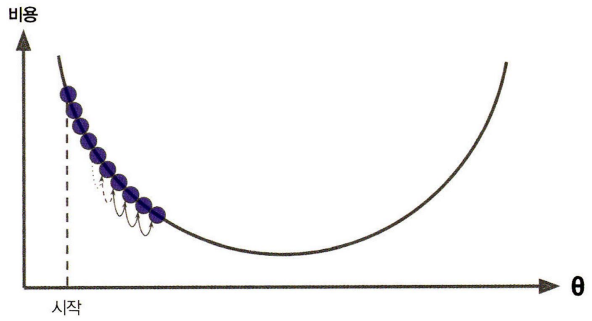
  
  - 너무 크면 : 알고리즘이 더 큰 값으로 발산할 수 있음
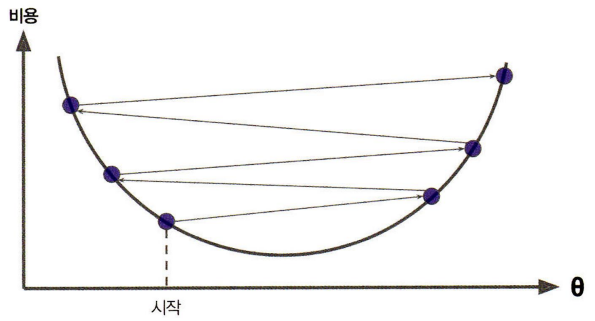

- 경사 하강법을 사용할 때는 반드시 모든 특성이 같은 스케일을 갖도록 만들어야 함 ex) StandardScaler
- 그렇지 않으면 수렴하는데 훨씬 오래 걸림

### 4.2.1 배치 경사 하강법

- 배치 경사 하강법 : 매 스텝에서 전체 훈련 세트 X에 대해 계산
  - 매우 큰 훈련 세트에서는 아주 느림
  - but 특성 수에 민감하지 않음
- 편도 함수 : 각 모델 파라미터에 대해 비용 함수의 그래디언트를 계산하는 함수

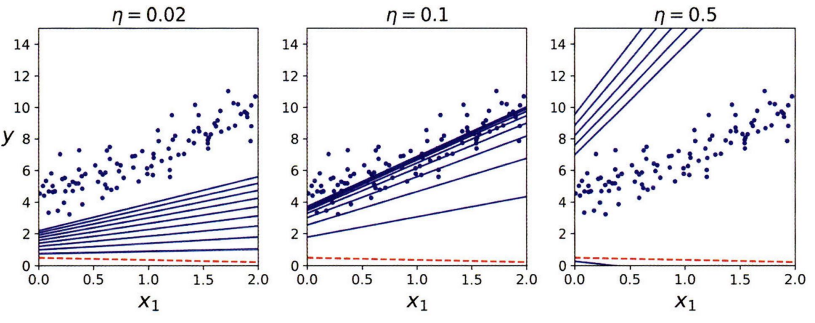

- 학습률이 너무 낮으면 : 시간이 오래 걸림
- 적당한 학습률 : 많이 반복하지 않아도 최적점에 수렴
- 학습률이 너무 높으면 : 최적점에서 점점 더 멀어져 발산함

  -> 적절한 학습률 찾기 위해 '그리드 탐색' 사용

In [ ]:
eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients

In [ ]:
theta

array([[4.56686608],
       [2.66713456]])

- 정규방정식으로 계산한 값과 같음

### 4.2.2 확률적 경사 하강법

- 확률적 경사 하강법(SGD) : 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그래디언트 계산
  - 매 반복에서 다루는 데이터가 매우 적기 때문에 **훨씬 빠름**
  - 매 반복에서 하나의 샘플만 메모리에 있으면 되므로 매우 큰 훈련 세트도 훈련 가능
  - but 확률적(무작위)이기 때문에 배치 경사 하강법보다 **훨씬 불안정**
- 시작할 때는 학습률을 크게, 점차적으로 줄여 전역 최솟값에 도달하게 함
  - 학습률이 너무 빨리 줄어들면 : 지역 최솟값에 갇히거나, 최솟값에 도달하기 전에 멈출 수 있음
  - 학습률이 너무 천천히 줄어들면 : 오랫동안 최솟값 주변을 맴돌거나 지역 최솟값에 머무를 수 있음
- 무작위 선택하기 때문에 샘플이 불균형하게 선택될 수 있음
 - 에포크마다 모든 샘플을 사용하려면 : 훈련 세트를 섞은 후 차례대로 하나씩 선택, 다음 에포크에서 다시 섞는 방법


In [ ]:
n_epochs = 50
t0, t1 = 5, 50 # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
  return t0 / (t + t1)

theta = np.random.randn(2,1) # 무작위 초기화

for epoch in range(n_epochs):
  for i in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index : random_index+1]
    yi = y[random_index : random_index+1]
    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(epoch * m + i)
    theta = theta - eta * gradients

- 한 반복에서 m번 되풀이, 각 반복을 에포크라고 함

In [ ]:
theta

array([[4.58988566],
       [2.62996184]])

In [ ]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

- max_iter=1000 : 최대 1000번 에포크 동안 실행
- tol=1e-3 : 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 실행
- eta0 = 0.1 : 학습률 0.1


In [ ]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.60154023]), array([2.74511088]))

### 4.2.3 미니배치 경사 하강법

- 미니배치 경사 하강법 : 각 스텝에서 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그래디언트 계산
  - GPU를 사용하면 성능 향상 가능
  - 미니 배치를 어느 정도 크게 하면 SGD보다 덜 불규칙적으로 움직임 -> SGD보다 최소값에 더 가까이 도달
  - but 지역 최솟값에서 빠져나오기는 더 힘듦

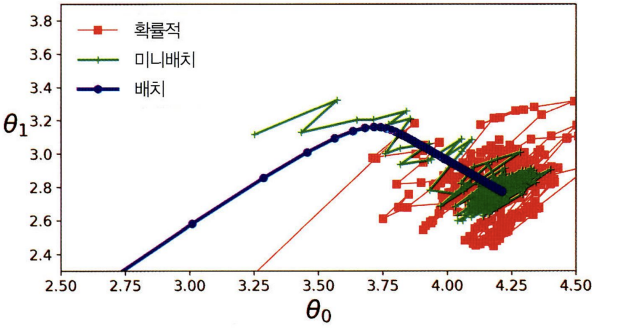

- 배치 경사 하강법 : 최솟값에서 멈춤 → 매 스텝에서 많은 시간 소요
- 확률적 경사 하강법 & 미니배치 경사 하강법 : 최솟값 근처에서 맴돌고 있음


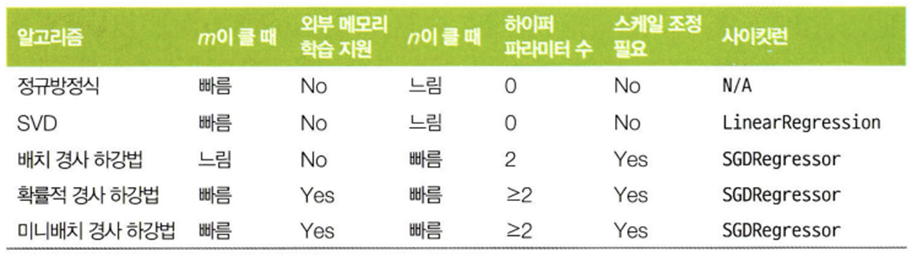

## 4.3 다항 회귀

다항 회귀 : 비선형 데이터를 학습하기 위해 선형 모델 사용하는 기법

In [ ]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

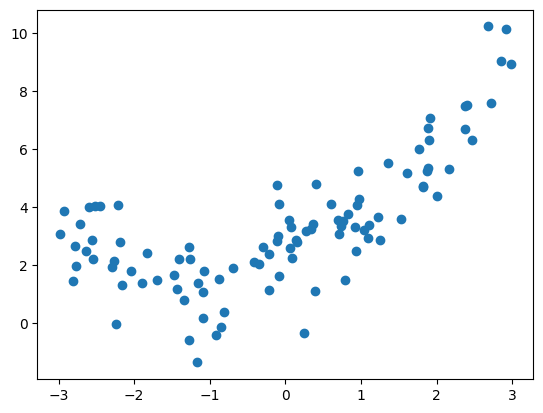

In [ ]:
plt.scatter(X, y)

- PolynomialFeatures를 사용해 훈련 데이터를 2차항으로 변환

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.35413846])

In [ ]:
X_poly[0]

array([-0.35413846,  0.12541405])

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.14933484]), array([[1.03667427, 0.46044362]]))

## 4.4 학습 곡선

[2차방정식으로 생성한 데이터]
- 고차 다항 회귀 모델 : 훈련 데이터에 심하게 과대적합
- 선형 모델 : 과소적합

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="훈련 세트")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증 세트")

- plot_learning_curves : 훈련 데이터에서 모델의 학습 곡선을 그리는 함수

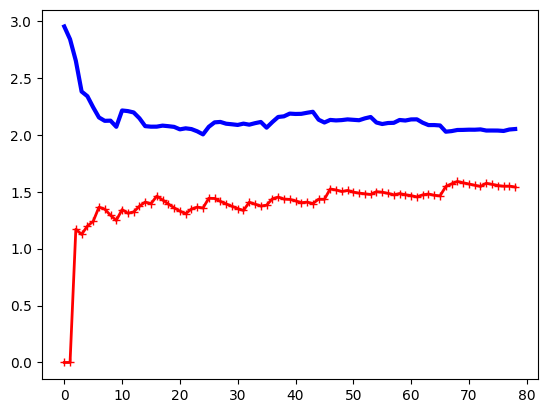

In [ ]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

- 파란색 : 검증 세트
- 빨간색 : 훈련 세트


- 위 그래프 : 단순 선형 회귀 학습곡선
  - 과소적합 모델의 전형적인 모습
  - 모델이 과소적합되어 있다면 훈련 샘플을 더 추가해도 효과 없음

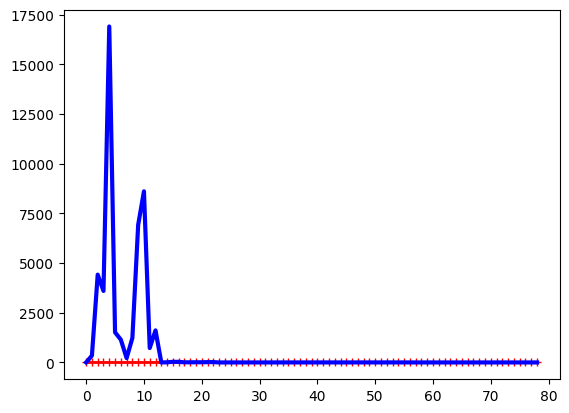

In [ ]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)

- 10차 다항 회귀 학습 곡선
  - 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮음
  - 과대적합 모델 개선 방법 : 검증 오차가 훈련 오차에 근접할 때까지 훈련 데이터 추가

- 편향/분산 트레이트오프
  - 모델의 복잡도가 커지면 일반적으로 분산이 늘어나고, 편향은 줄어듦

## 4.5 규제가 있는 선형 모델

- 과대적합 감소하는 좋은 방법 : 모델 규제
  - 다항 회귀 모델 규제 : 다항식의 차수 감소
  - 선형 회귀 모델 규제 : 모델의 가중치 제한

### 4.5.1 릿지 회귀

- 릿지 회귀(ridge) : 규제가 추가된 선형 회귀
  - 규제항이 비용 함수에 추가
  - 모델의 가중치가 가능한 한 작게 유지되도록 노력
  - 훈련 중 : 비용 함수에 규제항 추가
  - 훈련 후 : 모델의 성능을 규제가 없는 성능 지표로 평가

- 릿지 회귀의 비용 함수

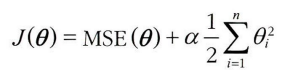

- 하이퍼 파라미터 α : 모델을 얼마나 많이 규제할지 조절
  - α=0 : 선형 회귀와 동일
  - α가 매우 크면 : 모든 가중치가 0에 가까워지고, 데이터의 평균을 지나는 수평선이 됨
- 릿지 회귀는 입력 특성 스케일에 민감 : 수행 전 데이터의 스케일 맞추는 것이 중요

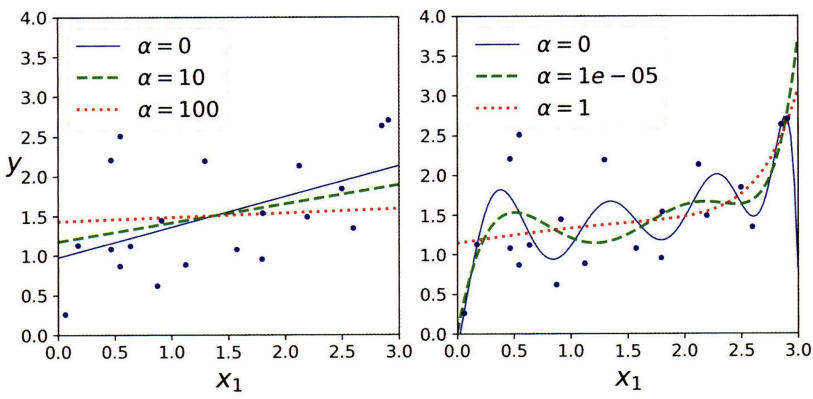

- α가 커질수록
  - 직선에 가까워짐
  - 모델의 분산은 줄지만, 편향은 커짐

- 정규방정식을 사용한 릿지 회귀

In [ ]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.79070062]])

- 확률적 경사 하강법을 사용한 릿지 회귀
  - penalty : 사용할 규제 지정
  - penalty='l2' : 릿지 회귀 (비용 함수에 가중치 벡터의 $l_{2}$ 노름의 제곱을 2로 나눈 규제항 추가)

In [ ]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.75018558])

### 4.5.2 라쏘 회귀

- Lasso(Least Absolute Shrinkage and Selection Opertor)
- 라쏘 회귀 : 비용 함수에 가중치 벡터의 $l_{1}$ 노름 사용
  - 덜 중요한 특성의 가중치를 제거
  - 자동으로 특성 선택을 하고 희소 모델을 만듦

- 라쏘 회귀의 비용 함수

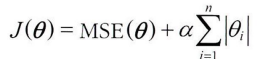

In [ ]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.73833455])

- Lasso 대신 SGDRegressor(penalty="l1") 사용 가능

### 4.5.3 엘라스틱넷

- 릿지 회귀와 라쏘 회귀를 절충한 모델
- 규제항 : 릿지와 라쏘의 규제항을 더해서 사용, 혼합 정도는 r을 사용해 조절
  - r=0 : 릿지 회귀와 같음
  - r=1 : 라쏘 회귀와 같음

- 엘라스틱넷 비용 함수

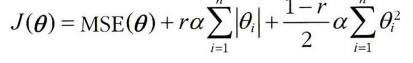

- 일반적으로 평범한 선형 회귀는 피해야 함 : 대부분의 경우에 규제가 있는 것이 좋음
- 기본적으로 '릿지 회귀' 사용
- 쓰이는 특성이 몇개 뿐이라고 의심되면 '라쏘'나 '엘라스틱넷' 사용
  - 특성 수가 훈련 샘플 수보다 많거나, 특성 몇 개가 강하게 연관되어 있을 때는 라쏘보다 '엘라스틱넷' 선호

In [ ]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.74153773])

- l1_ratio : 혼합 비율 r

### 4.5.4 조기 종료
- 조기 종료 : 검증 에러가 최솟값에 도달하면 훈련 중지
- 조기 종료하지 않으면 과대적합 가능성 있음(검증 에러 증가)

In [ ]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

# 데이터 준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train.ravel()) # 훈련을 이어서 진행합니다.
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    minumum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

## 4.6 로지스틱 회귀
- 로지스틱 회귀 : 샘플이 특정 클래스에 속할 확률 추정(분류에서 사용 가능), 이진 분류기

### 4.6.1 확률 추정

- 로지스틱 회귀 모델의 확률 추정

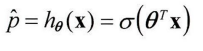
- 로지스틱 함수 : 0~1 사이의 값을 출력하는 시그모이드 함수

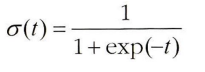

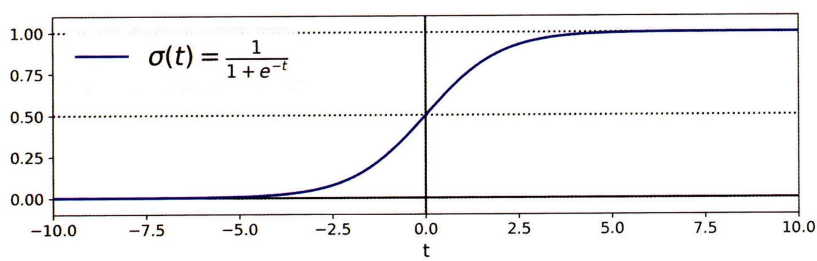

- t : 로짓, 로그-오즈
  - t < 0 → $\sigma$(t) < 0.5
  - t ≥ 0 → $\sigma$(t) ≥ 0.5

### 4.6.2 훈련과 비용 함수

- 로지스틱 회귀 모델 훈련 : 양성 샘플(y=1)에 대해 높은 확률을 추정하고 음성 샘플(y=0)에 대해 낮은 확률을 추정하는 모델의 파라미터 벡터 $\theta$를 찾는 것


- 하나의 훈련 샘플에 대한 비용 함수

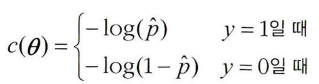

### 4.6.3 결정 경계

- 붓꽃 데이터셋 : 3개의 품종에 속하는 붓꽃 150개의 꽃잎(petal)과 꽃받침(sepal)의 너비와 길이

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [ ]:
X = iris['data'][:, 3:] # 꽃잎의 너비
y = (iris['target'] == 2).astype(int) # Iris_Virginica면 1, 그렇지 않으면 0

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

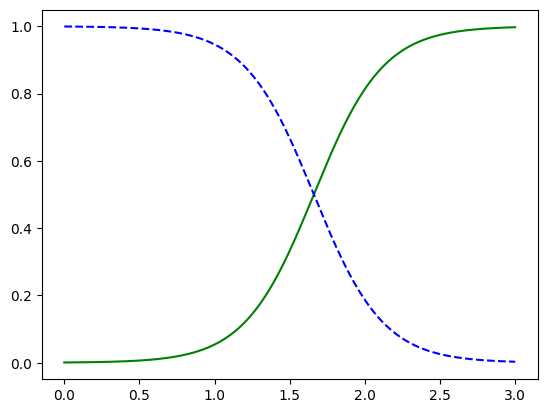

In [ ]:
X_new = np.linspace(0, 3, 1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")

- 꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률 계산
- 초록색 : Iris-Verginica
- 파란색 : not Iris-Verginica


- 양쪽의 확률이 똑같이 50%가 되는 1.6cm 근방에서 결정 경계 만들어짐
- 꽃잎 너비 > 1.6cm : Iris-Verginica로 분류
- 꽃잎 너비 < 1.6cm : Iris-Verginica가 아니라고 분류


In [ ]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

### 4.6.4 소프트맥스 회귀
- 소프트맥스 회귀(다항 로지스틱 회귀) : 직접 다중 클래스 지원
  - 샘플 x에 대하여 모델이 각 클래스 k에 대한 점수 $s_{k}(x)$를 계산 후, 소프트맥스 함수를 적용하여 각 클래스의 확률 추정

- 클래스 k에 대한 소프트맥스 점수

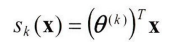

- 소프트맥스 함수 : 각 클래스의 점수에 지수 함수 적용 후 정규화(모든 지수 함수 결과의 합으로 나눔)

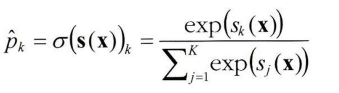

- K : 클래스 수
- s(x) : 샘플 x에 대한 각 클래스의 점수를 담은 벡터
- $\sigma(s(x))_{k}$ : 샘플이 클래스 k에 속할 추정 확률

- 소프트맥스 회귀 분류기 : 추정 확률이 가장 높은 클래스를 선택 (가장 높은 점수를 가진 클래스)
- Logistic Regression : 클래스가 2개 이상일 때 기본적으로 일대다(OvA) 전략 사용
  - multi_class="multinomial" : 소프트맥스 회귀
  - solver="lbfgs" : 소프트맥스 회귀 사용하려면 매개변수 solver에 소프트맥스 회귀를 지원하는 알고리즘 지정해야 함
  - C : $l_{2}$ 규제

In [ ]:
X = iris['data'][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = iris['target']

softmax_reg = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [ ]:
softmax_reg.predict([[5, 2]])

array([2])

In [ ]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])